<a href="https://colab.research.google.com/github/gustavocac/COVID_handson/blob/master/COVID_AI_Dasa_Educa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://github.com/gustavocac/COVID_hanson/blob/master/cdc-k0KRNtqcjfw-unsplash.jpg?raw=true)
Photo by CDC on Unsplash


# COVID 2019 

# Hands-on - Deep Learning for COVID Detection on CT 



**Developed by:**
DasaINOVA


Originally Branched and adapted from:

https://colab.research.google.com/github/gustavocac/rsna_handson/blob/master/RSNA_for_Non_Coders_final_version.ipynb


All the process will be demonstrated with Python 3 running on Google Colaboratory. 
Please make sure you have GPU enabled under notebook settings before you proceed.

Validation and Test sets have  normal and  COVID, except for dataset.

For each specific task we will import specific libraries.

After installation the the system will restart. This will generate an error message which is expected. 




In [1]:

import sys, os
!pip3 install keras-vis
!pip3 install imgaug==0.2.5
!pip3 install scipy==1.2.1
!pip3 install graphviz
!pip uninstall matplotlib --yes
!pip install matplotlib==3.1.0
!apt install p7zip-full



     |████████████████████████████████| 563kB 9.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp36-none-any.whl size=561439 sha256=e21edcd1434034e3149d59cd71853ea461cc71af11d0b40a307b7f6f4289a7e0
  Stored in directory: /root/.cache/pip/wheels/31/48/c8/ca3345e8582a078de94243996e148377ef66fdb845557bae0b
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 24.8MB 125kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.1 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
Uninstalling matplotlib-3.2.1:
  Successfully uninstalled matplotlib-3.2.1
     |████████████████████████████████| 13.1MB 243kB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is incompat

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Download e Unzip

In [3]:
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
!wget https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip?raw=true
!unzip -o CT_NonCOVID.zip?raw=true 
!unzip -o CT_COVID.zip?raw=true

--2020-04-20 16:00:08--  https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip [following]
--2020-04-20 16:00:08--  https://github.com/UCSD-AI4H/COVID-CT/raw/master/Images-processed/CT_COVID.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip [following]
--2020-04-20 16:00:09--  https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

Reset for next experiment

Dataset Selection and Preprocessing 

In [34]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
DIR = './CT_COVID'
DIRNC = './CT_NonCOVID'
cov=len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
non_cov= len([name for name in os.listdir(DIRNC) if os.path.isfile(os.path.join(DIRNC, name))])
print("Número de casos:")
print(cov)
print("Número de não casos:")
print(non_cov)
def f(x):
    return x
import os
print("Escolha o número de cortes positivos no dataset")
COVID=interactive(f, x=widgets.IntSlider(min=0, max=cov, step=1, value=400));

display(COVID)
print("Escolha o número de cortes não positivos no dataset")
N_COVID=interactive(f, x=widgets.IntSlider(min=0, max=non_cov, step=1, value=400));
display(N_COVID)
#print(COVID)


Número de casos:
349
Número de não casos:
397
Escolha o número de cortes positivos no dataset


interactive(children=(IntSlider(value=349, description='x', max=349), Output()), _dom_classes=('widget-interac…

Escolha o número de cortes não positivos no dataset


interactive(children=(IntSlider(value=397, description='x', max=397), Output()), _dom_classes=('widget-interac…



```
Separando 60% para treino, 10% para validação e 30% para teste.
```



In [0]:
C=COVID.result
N=N_COVID.result
CTR=round(0.6*C)
CV=round(0.1*C)
CTE=round(0.3*C)
NTR=round(0.6*N)
NV=round(0.1*N)
NTE=round(0.3*N)

import os
import sys
import shutil
import glob 
from glob import glob 
# Get directory name
mydir= "cases/"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Criando diretórios")
!mkdir cases
!mkdir cases/temp/
!mkdir cases/temp/COVID
!mkdir cases/temp/nonCOVID
!mkdir cases/Validation/
!mkdir cases/Validation/N
!mkdir cases/Validation/C
!mkdir cases/Test/
!mkdir cases/Test/C
!mkdir cases/Test/N
!mkdir cases/Training/
!mkdir cases/Training/N
!mkdir cases/Training/C
!mkdir cases/Test/all/


from shutil import copyfile
from os import listdir
files_C=glob("./CT_COVID/*.*")
files_NC=glob("./CT_NonCOVID/*.*")
x=1
x1=1
x2=1
for f in files_NC:
    if x<=NTR:
      y=str(x)
      shutil.copy(f,'./cases/Training/N/'+y+".png")
    x=x+1
    if x>NTR:
      if x1<=NV:
         y=str(x)
         shutil.copy(f,'./cases/Validation/N/'+y+".png")
      x=x+1
      x1=x1+1
      if x1>NV:
        if x2<=NTE:
           y=str(x)
           shutil.copy(f,'./cases/Test/N/'+y+".png")
           shutil.copy(f,'./cases/Test/all/'+y+".png")
           x=x+1
           x1=x1+1
           x2=x2+1
x=1
x1=1
x2=1
for f in files_C:
    if x<=CTR:
      y=str(x)
      shutil.copy(f,'./cases/Training/C/'+y+"c.png")
    x=x+1
    if x>CTR:
      if x1<=CV:
         y=str(x)
         shutil.copy(f,'./cases/Validation/C/'+y+"c.png")
      x=x+1
      x1=x1+1
      if x1>CV:
        if x2<=NTE:
           y=str(x)
           shutil.copy(f,'./cases/Test/C/'+y+"c.png")
           shutil.copy(f,'./cases/Test/all/'+y+"c.png")
           x=x+1
           x1=x1+1
           x2=x2+1




In [0]:
#@title Dataset Selection and Preprocessing {display-mode: "form"}
import os

#Dataset = "397/40" #@param ["397/40", "160/160", "349/349"]
Augmentation = "on" #@param ["off", "on", "custom"]
angle = 2 #@param {type:"slider", min:0, max:359, step:1}
zoom = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
width_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
height_shift_range = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
shear_range = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
horizontal_flip = True #@param {type:"boolean"}

# Importing libraries for arrays (NumPy), Pre-processing (Keras) and plotting images (Matplotlib)
%tensorflow_version 1.x
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
# It is important to set a random seed in order to have reproducbility of training results between different users
# SET ALL THE SEEDS
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)
os.environ['PYTHONHASHSEED'] = '123'
import random
random.seed(123)


In [37]:
import os
# Dimensions which our images will be resized for the input. All of them must have the same size
validation_data_dir = './cases/Validation/'
test_data_dir = './cases/Test/'
train_data_dir = './cases/Training/'
nb_train_samples=len(glob(train_data_dir + "C/*"))+len(glob(train_data_dir + "N/*"))
nb_test_samples= len(glob(test_data_dir + "C/*"))+len(glob(test_data_dir + "N/*"))
nb_validation_samples= len(glob(validation_data_dir + "C/*"))+len(glob(validation_data_dir + "N/*"))
print('Treino:')
print(nb_train_samples)
print('Teste:')
print(nb_test_samples)
print('Validação:')
print(nb_validation_samples)


Treino:
447
Teste:
226
Validação:
75


In [8]:
len(glob(train_data_dir + "C/*"))

209

Data Augmentation ON
Training set:
Found 447 images belonging to 2 classes.
Validation set:
Found 75 images belonging to 2 classes.
Test set:
Found 452 images belonging to 3 classes.

          Training Set Distribution


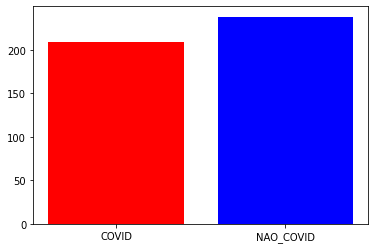


          Validation Set Distribution


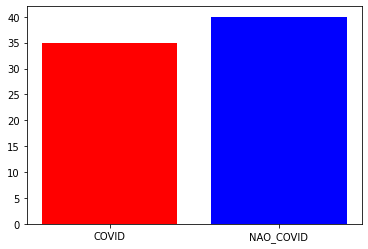


          Test Set Distribution


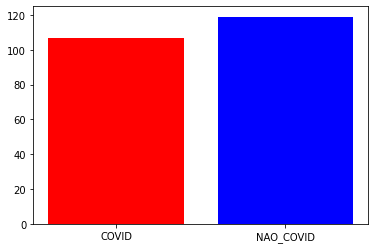


Now let's see some examples



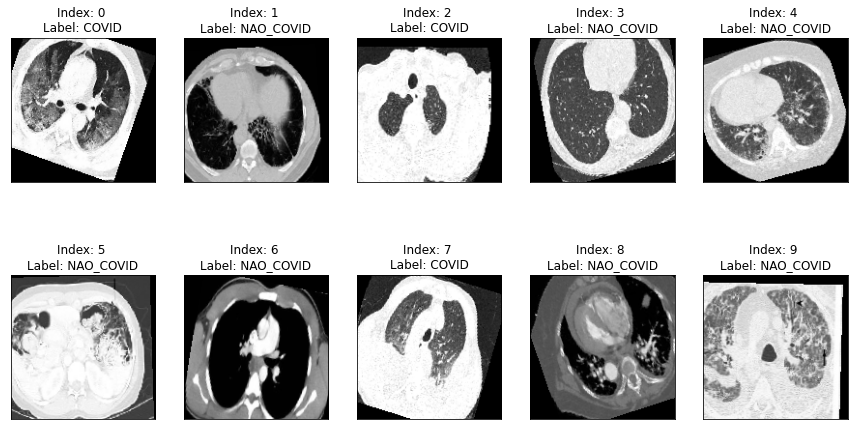

Ready for next step!


In [45]:

img_width, img_height = 150, 150

ds_size = {
    "Train_COVID": len(glob(train_data_dir + "C/*")),
    "Train_NAO_COVID": len(glob(train_data_dir + "N/*")),
    "Val_COVID": len(glob(validation_data_dir + "C/*")),
    "Val_NAO_COVID": len(glob(validation_data_dir + "N/*")),
    "Test_COVID": len(glob(test_data_dir + "C/*")),
    "Test_NAO_COVID": len(glob(test_data_dir + "N/*")),
}

# For generator we need to give these two hyperparameters
epochs = 40
batch_size = 10


# This is the augmentation configuration we will use for training
dataaug = Augmentation

if dataaug == "off":
  print("Data Augmentation OFF")
  train_datagen = ImageDataGenerator(
      rescale=1. / 255) # normalization
elif dataaug == "on":
  print("Data Augmentation ON")
  train_datagen = ImageDataGenerator(
      rescale=1. / 255, # normalization
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      rotation_range=20,
      fill_mode="constant",
      horizontal_flip=True)  
else:
  print("Data Augmentation Custom")
  train_datagen = ImageDataGenerator(
      rescale=1. / 255, # normalization
      width_shift_range=width_shift_range,
      height_shift_range=height_shift_range,
      shear_range=shear_range,
      fill_mode="constant",
      zoom_range=zoom, 
      rotation_range=angle,
      horizontal_flip=horizontal_flip)

# This is the augmentation configuration we will use for validation:
val_datagen = ImageDataGenerator(rescale=1. / 255) # normalization

test_datagen = ImageDataGenerator(rescale=1. / 255) # normalization

print("Training set:")
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

print("Validation set:")
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

print("Test set:")
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_test_samples,
    class_mode='binary', shuffle = False)



#Let's plot the class frequencies

print ('\033[1m' + '\r\n          Training Set Distribution')
plt.figure()
plt.bar([0, 1], [ds_size['Train_COVID'], ds_size['Train_NAO_COVID']], color=['red', 'blue'])
plt.xticks([0, 1], ('COVID', 'NAO_COVID'))
plt.show()

print ('\033[1m' + '\r\n          Validation Set Distribution')
plt.figure()
plt.bar([0, 1], [ds_size['Val_COVID'], ds_size['Val_NAO_COVID']], color=['red', 'blue'])
plt.xticks([0, 1], ('COVID', 'NAO_COVID'))
plt.show()

print ('\033[1m' + '\r\n          Test Set Distribution')
plt.figure()
plt.bar([0, 1], [ds_size['Test_COVID'], ds_size['Test_NAO_COVID']], color=['red', 'blue'])
plt.xticks([0, 1], ('COVID', 'NAO_COVID'))
plt.show()

# Let's plot the first 4 generator outputs, defining the positive cases as Label = True and negatives as Label = False 

print ('\033[1m' + '\r\nNow let\'s see some examples\r\n')

x,y = train_generator.next()

labley = y==0
#shape = x.shape
#print (shape)
#for i in range(0, 8):
#  plt.subplot(240 + 1 + i).grid(False)
#  plt.imshow(x[i], cmap=plt.get_cmap('gray'))
#  plt.title("\nLable:{}".format(labley[i]))
#  plt.axis('off')

start_idx = 0
fig, ax = plt.subplots(2,5, figsize=(15,8))
for j in range(0,2): 
  for i in range(0,5):
     ax[j][i].xaxis.set_major_locator(plt.NullLocator())
     ax[j][i].yaxis.set_major_locator(plt.NullLocator())
     ax[j][i].imshow(x[start_idx], cmap='gray')
     ax[j][i].set_title("Index: {} \nLabel: {}".format(start_idx, 'COVID' if y[start_idx]==0 else 'NAO_COVID'))
     start_idx +=1
plt.show()

# show the plot
plt.show()

print ('\033[1m' + 'Ready for next step!')


In [46]:


transfer_learning = "VGG16+ImageNet" #@param ["None", "VGG16+ImageNet"]

# This code will be hidden when the notebook is loaded.
# We can improve our results using transfer learning

from keras.applications.vgg16 import VGG16
if transfer_learning=="None":
  base_model = VGG16(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
else:
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Let's edit the last layers of VGG16 to use it in our solution

from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D

from keras.models import Model

from keras.callbacks import ModelCheckpoint

from keras import optimizers

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Only for version 2
x = Dense(1024, activation='relu')(x)

# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

SIIM_Net= Model(inputs=base_model.input, outputs=predictions)

# We can try using a different optimizer as well

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

SIIM_Net.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])


print ('\033[1m' + 'Ready for next step!')

Ready for next step!


Epoch 1/40
44/44 [==============================] - 5s 105ms/step - loss: 0.6900 - accuracy: 0.5217 - val_loss: 0.6192 - val_accuracy: 0.5286

Epoch 00001: val_loss improved from inf to 0.61918, saving model to Best_model.hdf5
Epoch 2/40
44/44 [==============================] - 5s 109ms/step - loss: 0.6675 - accuracy: 0.5950 - val_loss: 0.7002 - val_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 0.61918
Epoch 3/40
44/44 [==============================] - 5s 109ms/step - loss: 0.6576 - accuracy: 0.6250 - val_loss: 0.6210 - val_accuracy: 0.7231

Epoch 00003: val_loss did not improve from 0.61918
Epoch 4/40
44/44 [==============================] - 5s 103ms/step - loss: 0.6304 - accuracy: 0.6475 - val_loss: 0.5339 - val_accuracy: 0.6615

Epoch 00004: val_loss improved from 0.61918 to 0.53386, saving model to Best_model.hdf5
Epoch 5/40
44/44 [==============================] - 5s 105ms/step - loss: 0.6093 - accuracy: 0.6888 - val_loss: 0.5228 - val_accuracy: 0.7077

Epoch 00005

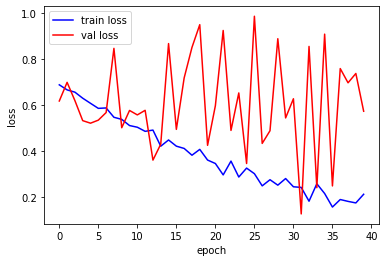

KeyError: ignored

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

checkpointer = ModelCheckpoint(filepath='Best_model.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True)

hist = SIIM_Net.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size,
            callbacks=[checkpointer])

#Plotting the loss function

plt.plot(hist.history['loss'], 'b-', label='train loss')
plt.plot(hist.history['val_loss'], 'r-', label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(hist.history['acc'], 'b-', label='train accuracy')
plt.plot(hist.history['val_acc'], 'r-', label='val accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()


print('\033[1m' + "Best Validation Accuracy: {:.2f}%".format(hist.history['val_acc'][np.argmin(hist.history['val_loss'])]*100.))
print("  ")

| NAO_COVID    | COVID    |
|--------------+----------|
| [[2.00e-01]  | [[0.9 ]  |
|  [1.32e-01]  |  [0.85]  |
|  [8.74e-02]  |  [0.57]  |
|  [9.82e-01]  |  [1.  ]  |
|  [8.37e-01]  |  [0.94]  |
|  [1.08e-01]  |  [0.95]  |
|  [9.90e-01]  |  [0.65]  |
|  [4.42e-02]  |  [0.98]  |
|  [7.46e-02]  |  [0.58]  |
|  [1.75e-02]  |  [0.03]  |
|  [2.13e-02]  |  [1.  ]  |
|  [4.19e-01]  |  [0.99]  |
|  [4.06e-03]  |  [0.99]  |
|  [8.32e-04]  |  [0.96]  |
|  [7.88e-01]  |  [0.88]  |
|  [8.24e-01]  |  [0.94]  |
|  [7.92e-01]  |  [0.18]  |
|  [1.72e-03]  |  [1.  ]  |
|  [3.32e-02]  |  [1.  ]  |
|  [1.47e-02]  |  [0.62]  |
|  [3.53e-02]  |  [0.81]  |
|  [6.63e-02]  |  [0.89]  |
|  [3.34e-01]  |  [0.95]  |
|  [1.35e-01]  |  [0.08]  |
|  [9.84e-03]  |  [0.72]  |
|  [1.76e-01]  |  [0.02]  |
|  [1.36e-02]  |  [1.  ]  |
|  [2.27e-03]  |  [0.99]  |
|  [1.86e-02]  |  [0.98]  |
|  [4.67e-01]  |  [1.  ]  |
|  [2.70e-01]  |  [0.99]  |
|  [2.04e-01]  |  [1.  ]  |
|  [2.48e-02]  |  [1.  ]  |
|  [1.22e-02]  |  [0

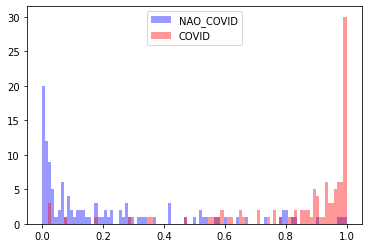

Ready for next step!


In [48]:


from keras.models import load_model
from tabulate import tabulate

#Loading the best model

best_model = load_model('Best_model.hdf5')

X, Y = test_generator.next() # Get the X (images) and Y (labels) of the test set

labels_pred = best_model.predict(X) #predict the output from X

labels_test = Y

np.set_printoptions(precision=2)

Y_neg = (1-labels_pred[labels_test == 1])

Y_pos = (1-labels_pred[labels_test == 0])
headers = ["NAO_COVID", "COVID"]
print(tabulate([[Y_neg,Y_pos]],headers,tablefmt="orgtbl"))

bins = np.linspace(0, 1, 100)

plt.figure()
plt.hist(Y_neg, bins, alpha=0.4, label='NAO_COVID', color='b')
plt.hist(Y_pos, bins, alpha=0.4, label='COVID', color='r')
plt.legend(loc='upper center')
plt.show()

print ('\033[1m' + 'Ready for next step!')

Accuracy: 0.00%


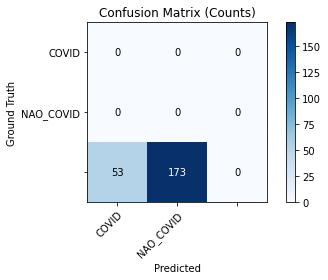

In [49]:
#@title Algorithm Performance (test set) - 2 x 2 table { display-mode: "form" }
threshold = 0.95 #@param {type:"slider", min:0, max:1, step:0.01}
threshold = 1-threshold
# This code will be hidden when the notebook is loaded.

from sklearn import metrics

from keras.models import load_model

#Loading the best model

best_model = load_model('Best_model.hdf5')


# Defining a function to plot a confusion matrix.

# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = '2x2 table'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Ground Truth',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

X, Y = test_generator.next() # Get the X (images) and Y (labels) of the test set

labels_pred = best_model.predict(X) #predict the output from X

#labels_pred = labels_pred > labels_pred.mean() #predictions greater than mean are set to 1, those lesser than or equal to mean are set to 0.

labels_pred = labels_pred >= threshold

labels_test = Y

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels_test, labels_pred.astype('int'), classes=['COVID','NAO_COVID'], normalize=False,
                      title='Confusion Matrix (Counts)')

accuracy = metrics.accuracy_score(labels_test, labels_pred)

print("Accuracy: {:.2f}%".format(accuracy*100.))

#print ('\033[1m' + 'Ready for next step!')

In [50]:
#@title Algorithm Performance (test set) - ROC Curve {display-mode: "form"}

threshold = 0.92 #@param {type:"slider", min:0, max:1, step:0.01}
threshold = 1-threshold

#Plotting the ROC curve with the AUC

labels_pred = best_model.predict(X) # predict again to get the original sigmoid output [0,1]

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(labels_test, labels_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr[np.argmin(np.abs(thresholds-threshold))],tpr[np.argmin(np.abs(thresholds-threshold))], 'o', color='red')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#labels_pred = labels_pred > labels_pred.mean() #predictions greater than mean are set to 1, those lesser than or equal to mean are set to 0.

labels_pred = labels_pred >= threshold

f1_score = metrics.f1_score(labels_test, labels_pred, labels=None, pos_label=0, average='binary', sample_weight=None)

accuracy = metrics.accuracy_score(labels_test, labels_pred)

print("Accuracy: {:.2f}%".format(accuracy*100.))

print("F1 Score: {:.4f}".format(f1_score))

print ('\033[1m' + 'Ready for next step!')

ValueError: ignored

In [32]:
#@title Test Evaluation - Prediction on sampled images {display-mode: "form"}
threshold = 0.55 #@param {type:"slider", min:0, max:1, step:0.01}
threshold = 1-threshold

# Finally, we can use the test set for predictions

import warnings
warnings.filterwarnings('ignore')

test_data_dir = './cases/Test/all/'

test_datagen = ImageDataGenerator(
         rescale=1./255)       # normalize pixel values to [0,1]

# Preparing test set images for prediction

itr = test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=40,
    shuffle='False',
    class_mode='binary')
batch_x, batch_y = itr.next()

print('Test Accuracy: {:.2f}%'.format(100.*best_model.evaluate(batch_x, batch_y, verbose=0)[1]))



from random import randrange

#prediction1 = np.round(best_model.predict(batch_x, verbose=1))==0
prediction = best_model.predict(batch_x, verbose=1)

start_idx = randrange(batch_x.shape[0]-10) 
fig, ax = plt.subplots(2,5, figsize=(15,8))
for j in range(0,2): 
  for i in range(0,5):
     ax[j][i].xaxis.set_major_locator(plt.NullLocator())
     ax[j][i].yaxis.set_major_locator(plt.NullLocator())
     ax[j][i].imshow(batch_x[start_idx], cmap='gray')
     ax[j][i].set_title("Index: {} \nPrediction: {} \nValue: {:.2f}".format(start_idx, 'COVID' if prediction[start_idx]<threshold else 'Normal', 1-prediction[start_idx][0]))
     start_idx +=1
plt.show()

print ('\033[1m' + 'Ready for next step!')

Found 0 images belonging to 0 classes.


IndexError: ignored

In [28]:
#@title Visualization - Saliency Maps {display-mode: "form"}

import warnings
warnings.filterwarnings('ignore')

# Importing visualization tools

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import initializers
from keras.models import Sequential, Model
from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import matplotlib.pyplot as plt
from keras.applications import imagenet_utils
import numpy as np

layer_idx = utils.find_layer_idx(best_model, 'block5_conv3')
print("Remove Activation from Last Layer")
# Swap softmax with linear
best_model.layers[layer_idx].activation = activations.linear
print("Done. Now Applying changes to the model ...")
activation2_model = utils.apply_modifications(best_model)

#print(activation_model.summary())
#im_files=["/All cases/Test/COVID/Test COVID (1).png","/All cases/Test/Normal/Test_normal (1).png"]
import os
cwd = os.getcwd()
import os

dir_name='/Cases/All cases/Test/'
im_files = test_generator.filenames
for im_file in im_files[3:6]:
    img1 = image.load_img(dir_name + im_file,target_size=(150,150))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)
    img1 = preprocess_input(img1)
    layer_idx = utils.find_layer_idx(activation2_model, 'block5_conv3')
    heatmap = visualize_cam(activation2_model, layer_idx, filter_indices=range(activation2_model.layers[layer_idx].filters), seed_input=img1[0,:,:,:])
    img_init=utils.load_img(dir_name + im_file,target_size=(150,150))
    img_init = img_init[:,:,:3]
    plt.figure(figsize=(10,10))
    ax1 = plt.subplot(1,3,1)
    ax1.grid(False)
    plt.imshow(img_init, cmap='gray')
    ax2 = plt.subplot(1,3,2)
    ax2.grid(False)
    plt.imshow(heatmap)
    ax3 = plt.subplot(1,3,3)
    ax3.grid(False)
    plt.imshow(overlay(img_init, heatmap))
    plt.show()
    
#print ('\n' + '\033[1m' + 'Congratulations, you have completed the assignment!')

#from IPython.display import HTML
#HTML('<img src="https://media.giphy.com/media/cub3pntkz8muQ/giphy.gif">')

Remove Activation from Last Layer
Done. Now Applying changes to the model ...


FileNotFoundError: ignored